In [212]:
import pandas as pd
import numpy as np
import requests
import json
from tqdm import tqdm
from scipy import stats

df = pd.read_excel('data/asap-aes/training_set_rel3.xlsx')

df_sample = df[df["essay_set"] == 8][0:1]

API_BASE_URL = "http://localhost:8000/api"

import time

def create_submission(essay, assignment_id):
    response = requests.post(f"{API_BASE_URL}/submissions/submit_text/", json={
        "content": essay,
        "assignment": assignment_id, 
        "student_name": "Anonymous"
    })
    if response.status_code != 201:
        print(f"Error creating submission: {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    return response.json()
    
import time

def process_submissions(df_sample, assignment_id):
    system_grades = []
    submission_ids = []
    
    for _, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
        # Create submission
        submission = create_submission(row['essay'], assignment_id)
        if submission is None:
            continue
        
        # Print submission response for debugging
        print(f"Submission response: {submission}")
        
        # Check if 'id' is in the response, if not, use an alternative field or skip
        if 'id' in submission:
            submission_id = submission['id']
        else:
            print(f"Unable to find submission ID in response: {submission}")
            continue
        
        submission_ids.append(submission_id)
        
        # Wait for grading to complete and get results
        max_attempts = 20
        attempt = 0
        while attempt < max_attempts:
            result = get_grading_results(submission_id)
            print("RESULT", result)
            if result['status'] == 'graded':
                system_grades.append(result['overall_score'])
                break
            time.sleep(10)  # Wait for 10 seconds before checking again
            attempt += 1
        
        if attempt == max_attempts:
            print(f"Grading not completed for submission {submission_id} after {max_attempts} attempts")
            system_grades.append(None)
    
    return submission_ids, system_grades

def get_grading_results(submission_id):
    response = requests.get(f"{API_BASE_URL}/submissions/{submission_id}/")
    data = response.json()
    
    # Print the full response for debugging
    print(f"Full API response for submission {submission_id}:")
    print(json.dumps(data, indent=2))
    
    if data.get('status') == 'graded' and 'category_scores' in data:
        category_scores = data['category_scores']
        
        if category_scores and isinstance(category_scores[0], dict) and 'categories' in category_scores[0]:
            categories = category_scores[0]['categories']
            
            valid_scores = [cat['score'] for cat in categories if isinstance(cat.get('score'), (int, float))]
            
            if valid_scores:
                overall_score = sum(valid_scores) / len(valid_scores)
                return {
                    'status': 'graded',
                    'overall_score': overall_score / 6  # Assuming the max score is 6
                }
    
    # If we couldn't extract a valid score or the submission is not graded
    return {
        'status': 'pending',
        'overall_score': None
    }
    
assignment_id = 12
try:
    submission_ids, system_grades = process_submissions(df_sample, assignment_id)

    # Create a DataFrame with all grades
    comparison_df = pd.DataFrame({
        'Submission ID': submission_ids,
        'Rater1 Grade': df_sample['rater1_domain1'].values[:len(submission_ids)] / 6,
        'Rater2 Grade': df_sample['rater2_domain1'].values[:len(submission_ids)] / 6,
        'System Grade': system_grades
    })

    # Print out the first few rows of the DataFrame for verification
    print("\nFirst few rows of the comparison DataFrame:")
    print(comparison_df.head())

except Exception as e:
    print(f"An error occurred: {str(e)}")

# Calculate correlations
def calculate_correlations(df):
    correlations = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                pearson, _ = stats.pearsonr(df[col1][mask], df[col2][mask])
                spearman, _ = stats.spearmanr(df[col1][mask], df[col2][mask])
                correlations[f"{col1} vs {col2}"] = {
                    'Pearson': pearson,
                    'Spearman': spearman
                }
    return correlations

correlations = calculate_correlations(comparison_df)
print("Correlations:")
print(json.dumps(correlations, indent=2))

# Calculate and print mean absolute error
def calculate_mae(df):
    mae = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                mae[f"{col1} vs {col2}"] = np.mean(np.abs(df[col1][mask] - df[col2][mask]))
    return mae

mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(json.dumps(mae, indent=2))

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)

# # Function to get knowledge base items
# def get_knowledge_base_items():
#     response = requests.get(f"{API_BASE_URL}/knowledge-base/")
#     return response.json()

# # Analyze knowledge base items
# kb_items = get_knowledge_base_items()
# unapproved_items = [item for item in kb_items if item['status'] == 'pending']

# print(f"\nNumber of unapproved knowledge base items created: {len(unapproved_items)}")

# # Display some unapproved items for verification
# print("Sample unapproved knowledge base items:")
# for item in unapproved_items[:5]:  # Display first 5 items
#     print(json.dumps(item, indent=3))

100%|██████████| 1/1 [8:57:24<00:00, 32244.58s/it]

Error creating submission: 500
Response content: <!DOCTYPE html>
<html lang="en">
<head>
  <meta http-equiv="content-type" content="text/html; charset=utf-8">
  <meta name="robots" content="NONE,NOARCHIVE">
  <title>IntegrityError
          at /api/submissions/submit_text/</title>
  <style type="text/css">
    html * { padding:0; margin:0; }
    body * { padding:10px 20px; }
    body * * { padding:0; }
    body { font:small sans-serif; background-color:#fff; color:#000; }
    body>div { border-bottom:1px solid #ddd; }
    h1 { font-weight:normal; }
    h2 { margin-bottom:.8em; }
    h3 { margin:1em 0 .5em 0; }
    h4 { margin:0 0 .5em 0; font-weight: normal; }
    code, pre { font-size: 100%; white-space: pre-wrap; word-break: break-word; }
    summary { cursor: pointer; }
    table { border:1px solid #ccc; border-collapse: collapse; width:100%; background:white; }
    tbody td, tbody th { vertical-align:top; padding:2px 3px; }
    thead th {
      padding:1px 6px 1px 3px; background:#

ValueError: x and y must have length at least 2.

In [202]:
df[df["essay_set"] == 8][0:10].dropna(axis=1)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6
12255,20716,8,A long time ago when I was in third grade I h...,18.0,16.0,34.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0,3.0,3.0
12256,20717,8,Softball has to be one of the single most gre...,21.0,26.0,46.0,5.0,4.0,5.0,4.0,4.0,4.0,6.0,5.0,6.0,6.0,5.0,5.0
12257,20718,8,"Some people like making people laugh, I love ...",15.0,20.0,40.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0
12258,20719,8,"""LAUGHTER"" @CAPS1 I hang out with my friends...",12.0,20.0,30.0,3.0,3.0,3.0,3.0,2.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0
12259,20721,8,Well ima tell a story about the time i got @CA...,11.0,15.0,26.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0
12260,20722,8,@CAPS3 I'm going to tell @CAPS18 a little stor...,20.0,18.0,40.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,3.0
12261,20723,8,"My best friend, @PERSON1 and I have been clos...",20.0,20.0,40.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
12262,20724,8,Laughter is a really good thing to have in a...,15.0,19.0,34.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0,4.0,4.0,4.0
12263,20725,8,"I believe that with all people laughter, and ...",21.0,20.0,41.0,4.0,5.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
12264,20726,8,"Laughter, one of life's greatest gifts. Have ...",20.0,20.0,40.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0


In [194]:
comparison_df = comparison_df[comparison_df["System Grade"] != 0]

In [195]:
comparison_df

,Submission ID,Rater1 Grade,Rater2 Grade,System Grade
0,1210,0.666667,0.666667,0.583333
1,1211,0.833333,0.666667,0.541667
2,1212,0.666667,0.500000,0.416667
3,1213,0.833333,0.833333,0.583333
4,1214,0.666667,0.666667,NaN
5,1215,0.666667,0.666667,0.166667
6,1216,0.833333,0.833333,0.583333
7,1217,0.833333,0.833333,0.625000
8,1218,0.666667,0.833333,0.541667
9,1219,0.833333,0.666667,0.541667


In [196]:
mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(json.dumps(mae, indent=2))

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)


Mean Absolute Error:
{
  "Rater1 Grade vs Rater2 Grade": 0.04666666666666667,
  "Rater1 Grade vs System Grade": 0.23026315789473684,
  "Rater2 Grade vs Rater1 Grade": 0.04666666666666667,
  "Rater2 Grade vs System Grade": 0.20394736842105263,
  "System Grade vs Rater1 Grade": 0.23026315789473684,
  "System Grade vs Rater2 Grade": 0.20394736842105263
}

Summary Statistics:
       Submission ID  Rater1 Grade  Rater2 Grade  System Grade
count      25.000000     25.000000     25.000000     19.000000
mean     1222.000000      0.686667      0.653333      0.462719
std         7.359801      0.168874      0.179505      0.160111
min      1210.000000      0.333333      0.166667      0.166667
25%      1216.000000      0.666667      0.500000      0.354167
50%      1222.000000      0.666667      0.666667      0.541667
75%      1228.000000      0.833333      0.833333      0.583333
max      1234.000000      1.000000      1.000000      0.708333

Percentage of null values:
Submission ID     0.0
Rater1 

In [197]:
correlations = calculate_correlations(comparison_df)
print("Correlations:")
print(json.dumps(correlations, indent=2))

Correlations:
{
  "Rater1 Grade vs Rater2 Grade": {
    "Pearson": 0.8873218101542076,
    "Spearman": 0.8547741075628743
  },
  "Rater1 Grade vs System Grade": {
    "Pearson": 0.7043898782538628,
    "Spearman": 0.6527760190912871
  },
  "Rater2 Grade vs Rater1 Grade": {
    "Pearson": 0.8873218101542076,
    "Spearman": 0.8547741075628743
  },
  "Rater2 Grade vs System Grade": {
    "Pearson": 0.6557330674355457,
    "Spearman": 0.6452831021507747
  },
  "System Grade vs Rater1 Grade": {
    "Pearson": 0.7043898782538628,
    "Spearman": 0.6527760190912871
  },
  "System Grade vs Rater2 Grade": {
    "Pearson": 0.6557330674355457,
    "Spearman": 0.6452831021507748
  }
}


In [183]:
result

NameError: name 'result' is not defined

C:\Users\NDSU-Prof\AppData\Local\Temp\ipykernel_13568\2189312810.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  comparison_df[["Rater1 Grade", "Rater2 Grade", "System Grade"]].hist(ax=ax)


array([[<Axes: title={'center': 'Rater1 Grade'}>,
        <Axes: title={'center': 'Rater2 Grade'}>],
       [<Axes: title={'center': 'System Grade'}>, <Axes: >]], dtype=object)

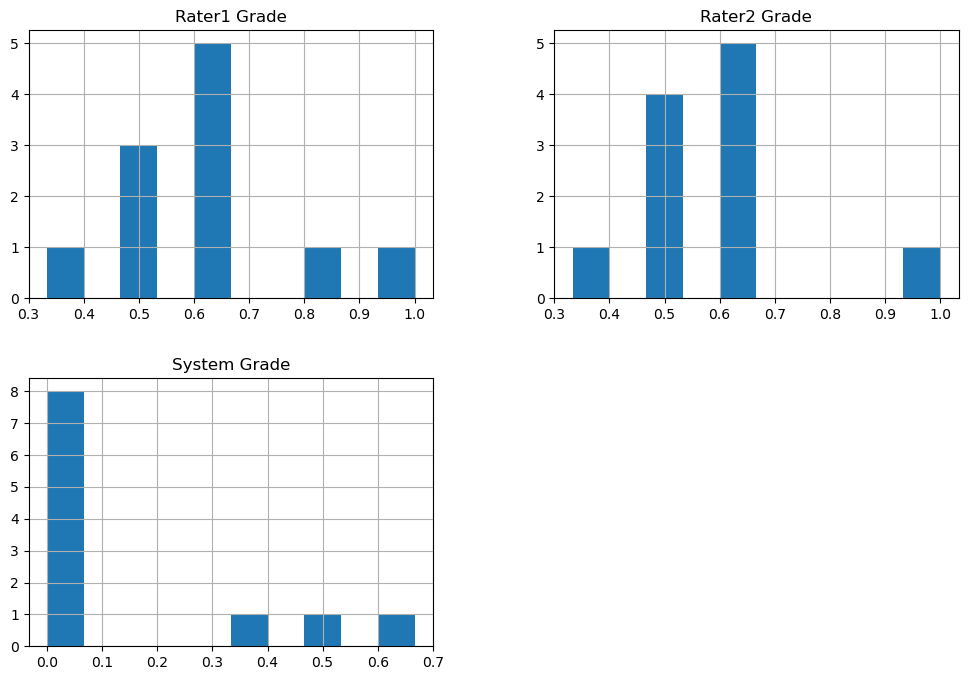

In [166]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,8))
comparison_df[["Rater1 Grade", "Rater2 Grade", "System Grade"]].hist(ax=ax)

In [167]:
submission_ids

[1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179]

In [168]:
comparison_df.to_excel('ratings_comparison_withrubric_andcritic_withknowledgebase1.xlsx')


In [169]:
pd.DataFrame.from_dict(correlations).to_excel('correlations_withrubric_andcritic_withknowledgebase1.xlsx')

In [170]:
comparison_df.describe().to_excel('summary_stats_withrubric_andcritic_withknowledgebase1.xlsx')

In [22]:
API_BASE_URL = "http://localhost:8000/api"

In [51]:
# Backend API URL
API_URL = "http://localhost:8000/api"

In [52]:
def fetch_submissions_with_cycles(assignment_id):
    response = requests.get(f"{API_BASE_URL}/submissions/with_knowledge_base_items/?assignment={assignment_id}")
    return response.json()

def normalize_score(score, min_score, max_score):
    return (score - min_score) / (max_score - min_score)


In [53]:
# Function to create a submission
def create_submission(essay):
    response = requests.post(f"{API_URL}/submissions/", json={
        "content": essay,
        "assignment": 22, 
        "student_name": "Anonymous"
    })
    return response.json()

In [54]:
# Function to get grading results
def get_grading_results(submission_id):
    response = requests.get(f"{API_URL}/submissions/{submission_id}/")
    return response.json()

In [55]:
# Function to get knowledge base items
def get_knowledge_base_items():
    response = requests.get(f"{API_URL}/knowledge-base/")
    return response.json()

In [56]:
assignment_id = 22  # Replace with the correct assignment ID
submissions_data = fetch_submissions_with_cycles(assignment_id)

# Process the data
processed_data = []
for submission in submissions_data:
    rater1_grade = submission.get('rater1_domain1')
    rater2_grade = submission.get('rater2_domain1')
    system_grade = submission.get('overall_score')
    
    if rater1_grade is not None:
        rater1_grade = normalize_score(rater1_grade, 0, 5)  # Assuming original scale is 0-5
    if rater2_grade is not None:
        rater2_grade = normalize_score(rater2_grade, 0, 5)  # Assuming original scale is 0-5
    
    processed_data.append({
        'Submission ID': submission['id'],
        'Rater1 Grade': rater1_grade,
        'Rater2 Grade': rater2_grade,
        'System Grade': system_grade
    })

comparison_df = pd.DataFrame(processed_data)

In [57]:
comparison_df

""


In [12]:

def calculate_correlations(df):
    correlations = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                pearson, _ = stats.pearsonr(df[col1][mask], df[col2][mask])
                spearman, _ = stats.spearmanr(df[col1][mask], df[col2][mask])
                correlations[f"{col1} vs {col2}"] = {
                    'Pearson': pearson,
                    'Spearman': spearman
                }
    return correlations

assignment_id = 22  # Replace with the correct assignment ID

response = requests.get(f"{API_URL}/assignments/{assignment_id}/")
assignment = response.json()
rubric = assignment['rubric']

# Calculate min and max scores based on the rubric
min_score = 1
max_score = len(rubric['categories']) + 1

# Function to normalize scores to 0-1 range
def normalize_score(score, min_score, max_score):
    return (score - min_score) / (max_score - min_score)

# Normalize Rater1 and Rater2 grades
comparison_df['Rater1 Grade Normalized'] = comparison_df['Rater1 Grade'].apply(lambda x: normalize_score(x, min_score, max_score))
comparison_df['Rater2 Grade Normalized'] = comparison_df['Rater2 Grade'].apply(lambda x: normalize_score(x, min_score, max_score))


In [13]:
comparison_df.sort_values(by="Rater1 Grade Normalized", ascending=False )


,Submission ID,Rater1 Grade,Rater2 Grade,System Grade,Rater1 Grade Normalized,Rater2 Grade Normalized
1,101,5.0,4.0,0.333333,4.0,3.0
3,103,5.0,5.0,0.500000,4.0,4.0
0,100,4.0,4.0,0.500000,3.0,3.0
2,102,4.0,3.0,0.333333,3.0,2.0
4,104,4.0,4.0,0.333333,3.0,3.0


In [169]:
correlations = calculate_correlations(comparison_df)
print("Correlations:")
print(json.dumps(correlations, indent=2))

Correlations:
{
  "Rater1 Grade vs Rater2 Grade": {
    "Pearson": 0.6454972243679029,
    "Spearman": 0.6454972243679028
  },
  "Rater1 Grade vs System Grade": {
    "Pearson": -0.6344412685745155,
    "Spearman": -0.6454972243679028
  },
  "Rater2 Grade vs Rater1 Grade": {
    "Pearson": 0.6454972243679029,
    "Spearman": 0.6454972243679028
  },
  "Rater2 Grade vs System Grade": {
    "Pearson": 0.0,
    "Spearman": 0.0
  },
  "System Grade vs Rater1 Grade": {
    "Pearson": -0.6344412685745155,
    "Spearman": -0.6454972243679028
  },
  "System Grade vs Rater2 Grade": {
    "Pearson": 0.0,
    "Spearman": 0.0
  }
}


In [136]:
# Calculate and print mean absolute error
def calculate_mae(df):
    mae = {}
    for col1 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
        for col2 in ['Rater1 Grade', 'Rater2 Grade', 'System Grade']:
            if col1 != col2:
                mask = ~np.isnan(df[col1]) & ~np.isnan(df[col2])
                mae[f"{col1} vs {col2}"] = np.mean(np.abs(df[col1][mask] - df[col2][mask]))
    return mae

mae = calculate_mae(comparison_df)
print("\nMean Absolute Error:")
print(json.dumps(mae, indent=2))


Mean Absolute Error:
{
  "Rater1 Grade vs Rater2 Grade": 0.4,
  "Rater1 Grade vs System Grade": 4.106666666666667,
  "Rater2 Grade vs Rater1 Grade": 0.4,
  "Rater2 Grade vs System Grade": 3.9066666666666663,
  "System Grade vs Rater1 Grade": 4.106666666666667,
  "System Grade vs Rater2 Grade": 3.9066666666666663
}


In [143]:
kb_items = get_knowledge_base_items()
unapproved_items = [kb_items[item] for item in kb_items]

print(f"\nNumber of unapproved knowledge base items created: {len(unapproved_items)}")

# Display some unapproved items for verification
print("Sample unapproved knowledge base items:")
for item in unapproved_items[:5]:  # Display first 5 items
    print(json.dumps(item, indent=3))

# Print summary statistics
print("\nSummary Statistics:")
print(comparison_df.describe())

# Print percentage of null values
print("\nPercentage of null values:")
print(comparison_df.isnull().mean() * 100)


Number of unapproved knowledge base items created: 4
Sample unapproved knowledge base items:
23
"http://localhost:8000/api/knowledge-base/?page=2"
null
[
   {
      "id": 29,
      "item_type": "grade",
      "content": {
         "submission_id": 84,
         "overall_score": 0.36666666666666664,
         "category_scores": [
            {
               "name": "Position Clarity",
               "score": 2,
               "justification": "The author's position opposing the use of computers in society is somewhat clear but lacks focus and cohesion, in line with the rubric description for a score of 2. The arguments presented, such as concerns about obesity, cramps, sexual harassment, and cyberbullying, are valid but are conveyed in a disjointed and confusing manner. There is an overarching lack of emphasis and conviction, which makes the stance difficult to fully understand. Additionally, the narrative sometimes drifts off-topic, further complicating clarity. To align better with th

In [4]:
try:
    df = pd.read_csv('data/asap-aes/test_set.tsv', sep='\t', encoding='ISO-8859-1')
    print("File loaded successfully")
except FileNotFoundError:
    print("File not found. Please check the file path.")
except pd.errors.ParserError:
    print("Error parsing the file. Please check the file format.")
except Exception as e:
    print(f"An error occurred: {e}")


File loaded successfully


In [7]:
df

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN
1,2384,1,"Dear @CAPS1, I know some problems have came up...",2384,NaN
2,2385,1,"Dear to whom it @MONTH1 concern, Computers are...",2385,NaN
3,2386,1,"Dear @CAPS1 @CAPS2, @CAPS3 has come to my atte...",2386,NaN
4,2387,1,"Dear Local newspaper, I think that people have...",2387,NaN
...,...,...,...,...,...
4249,22238,8,Just One @CAPS1 @CAPS2 can bring people togeth...,25238,NaN
4250,22239,8,@CAPS8 Was my first time going to the band ca...,25239,NaN
4251,22240,8,Laughter is one of the most important things i...,25240,NaN
4252,22241,8,A @CAPS1 Of @C...,25241,NaN
